# Optimal Transport for Domain Adaptation
> How to adapt a CNN between different domains using Optimal Transport

- toc: true 
- badges: true
- comments: true
- permalink: /:year/:month/:day/:title
- categories: [Optimal Transport,Transfer Learning,Image Classification]

The idea of this blog post is to give a deeper idea on __how__ to perform Optimal Transport for Domain Adaptation. Throughout this tutorial, we will use the works of Courty et al. [1], who were the first authors to propose using Optimal Transport for adapting models in a unsupervised way.

We do not give much details on how to perform Optimal Transport. We simply rely on the awesome library [Python Optimal Transport](https://pythonot.github.io/). For more information you can take a look on the textbook by Peyré and Cuturi [2]. In this tutorial, we explore how to adapt a Convolutional Neural Network for classifying slightly different digits.

In [1]:
#collapse_output
!pip install pot
!pip install torchinfo

     |████████████████████████████████| 664 kB 7.7 MB/s 


In [2]:
import ot
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

import torch

from torchinfo import summary
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import make_grid

from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier

In [3]:
device = 'cpu'

## Loading the datasets

For the transfer learning task, we will use MNIST [3] and USPS [4] datasets. These are very simillar datasets which consists on handwritten digits (in white) on a solid background (in black). Our goal is to adapt a model learned on MNIST to classify digits in USPS correctly.

This adaptation problem has been extensively studied by the community (e.g. [5, 6]). Here we provide a show case that does not focuses on performance. We perform the following preprocessing steps to the digits:

1. We convert each pixel from uint8 [0, 255] to float32 in [0, 1]. This is done by the ```transforms.ToTensor()``` call, as you can see below.
2. We resize each image to $32 \times 32$. Note that this introduces artifacts, especially in USPS digits which were $16 \times 16$ originally.
3. We replicate the image accross the 3 RGB channels

This is the step-by-step of the transform composition shown below.

In [5]:
T = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((32, 32))
])

Once the preprocessing pipeline is constructed, we can create source and target dataloaders

In [6]:
#collapse_output
src_dataset = datasets.MNIST(root='./.tmp', train=True, transform=T, download=True)
src_loader = torch.utils.data.DataLoader(dataset=src_dataset, batch_size=256, shuffle=True)

tgt_dataset = datasets.USPS(root='./.tmp', train=True, transform=T, download=True)
tgt_loader = torch.utils.data.DataLoader(dataset=tgt_dataset, batch_size=256, shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./.tmp/MNIST/raw/train-images-idx3-ubyte.gz to ./.tmp/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./.tmp/MNIST/raw/train-labels-idx1-ubyte.gz to ./.tmp/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./.tmp/MNIST/raw/t10k-images-idx3-ubyte.gz to ./.tmp/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./.tmp/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./.tmp/MNIST/raw



  0%|          | 0/6579383 [00:00<?, ?it/s]

We can see a few samples from both datasets by iterating through the dataloaders

In [7]:
for xs, ys in src_loader: break
for xt, yt in tgt_loader: break

Source Labels: tensor([[8, 6, 6, 2, 5, 7, 9, 2],
        [3, 1, 2, 8, 6, 3, 9, 1],
        [6, 9, 8, 1, 7, 7, 2, 4],
        [8, 9, 4, 5, 3, 6, 6, 1],
        [1, 9, 1, 9, 0, 0, 8, 9],
        [7, 2, 2, 9, 4, 2, 3, 6],
        [3, 0, 4, 6, 4, 4, 2, 4],
        [4, 7, 0, 4, 9, 4, 0, 6]])
Target Labels: tensor([[9, 0, 0, 0, 1, 1, 1, 9],
        [5, 7, 5, 7, 2, 4, 1, 9],
        [0, 3, 2, 9, 3, 0, 4, 8],
        [2, 0, 2, 7, 0, 1, 6, 3],
        [1, 2, 2, 5, 9, 3, 3, 0],
        [9, 4, 4, 8, 1, 2, 3, 0],
        [0, 0, 1, 7, 6, 3, 2, 0],
        [6, 7, 6, 9, 8, 1, 4, 8]])


(-0.5, 273.5, 273.5, -0.5)

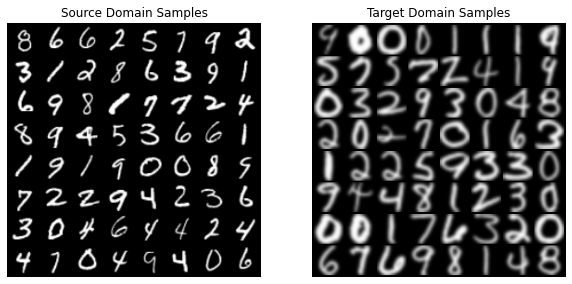

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

ind = np.random.choice(np.arange(len(xs)), size=64)
samples = xs[ind]
grid = make_grid(samples).numpy().transpose([1, 2, 0])
print('Source Labels: {}'.format(ys[ind].reshape(8, 8)))

axes[0].set_title('Source Domain Samples')
axes[0].imshow(grid)
axes[0].axis('off')

ind = np.random.choice(np.arange(len(xs)), size=64)
samples = xt[ind]
grid = make_grid(samples).numpy().transpose([1, 2, 0])
print('Target Labels: {}'.format(yt[ind].reshape(8, 8)))

axes[1].set_title('Target Domain Samples')
axes[1].imshow(grid)
axes[1].axis('off')

Note that even though much simillar, the source and target datasets are quite different. Especially, MNIST digits are centered on the grid $32 \times 32$, while USPS digits tend to occupy the whole grid. As it turns out this is quite important for the CNN, despite not interfering with human recognition.

This is an example of the known covariate shift phenomenon, which corresponds to when $P_{S}(X) \neq P_{T}(X)$. In other words, the marginal feature distribution changes accross domains. This happens when the statistical properties of the data change.

In what follows, we will,

* Load a CNN feature extractor and train it on MNIST
* Measure its performance on USPS
* Use Optimal Transport to enhance the performance on USPS.

## Loading a pretrained a Feature Extractor

Here we use the classical architecture LeNet5 [6], especifically designed for classifying MNIST digits. Here you can see its overall description.

![](https://www.datasciencecentral.com/wp-content/uploads/2021/10/1lvvWF48t7cyRWqct13eU0w.jpeg)

We code this network architecture using Pytorch's [Module API](https://pytorch.org/docs/stable/generated/torch.nn.Module.html).

In [45]:
class LeNet5(torch.nn.Module):
    def __init__(self, n_channels=3):
        self.n_channels = n_channels
        super(LeNet5, self).__init__()

        self.feature_extractor = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=n_channels, out_channels=6, kernel_size=5),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(stride=2, kernel_size=2),
            torch.nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(stride=2, kernel_size=2)
        )

        self.class_discriminator = torch.nn.Sequential(
            torch.nn.Linear(in_features=16 * 5 * 5, out_features=120),
            torch.nn.ReLU(),
            torch.nn.Linear(in_features=120, out_features=84),
            torch.nn.ReLU(),
            torch.nn.Linear(in_features=84, out_features=10),
            torch.nn.Softmax(dim=1)
        )

    def forward(self, x):
        y = self.feature_extractor(x)
        h = y.view(-1, 16 * 5 * 5)
        features = self.class_discriminator[:-2](h)
        predicted_labels = self.class_discriminator(h)

        return features, predicted_labels

note that our neural network architecture is now a class. To start using the model, we need to instantiate it into an object,

In [46]:
model = LeNet5(n_channels=1)

To further understand the architecture of LeNet5, we use [torchinfo](https://github.com/TylerYep/torchinfo), which further shows the number of parameters in the network.

In [47]:
summary(model, input_size=(100, 1, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
LeNet5                                   --                        --
├─Sequential: 1-1                        [100, 16, 5, 5]           --
│    └─Conv2d: 2-1                       [100, 6, 28, 28]          156
│    └─ReLU: 2-2                         [100, 6, 28, 28]          --
│    └─MaxPool2d: 2-3                    [100, 6, 14, 14]          --
│    └─Conv2d: 2-4                       [100, 16, 10, 10]         2,416
│    └─ReLU: 2-5                         [100, 16, 10, 10]         --
│    └─MaxPool2d: 2-6                    [100, 16, 5, 5]           --
├─Sequential: 1                          --                        --
│    └─Linear: 2-7                       [100, 120]                48,120
│    └─ReLU: 2-8                         [100, 120]                --
│    └─Linear: 2-9                       [100, 84]                 10,164
│    └─ReLU: 2-10                        [100, 84]                 --
├─S

Training the model consists on minimizing the Cross Entropy between the ground truth class vector (i.e. to which digit an image corresponds) and the predictions. This loss function is given by,

$$
\mathcal{L}(y, \hat{y}) = -\dfrac{1}{n}\sum_{i=1}^{n}\sum_{j=1}^{K}y_{ij}\log \hat{y}_{ij}
$$

where $n=256$ is the number of samples in the minibatch and $K$ is the number of classes in our problem. An important remark must be done here. During training we assume that labels come in an one hot encoding format. This means that each categorical value (i.e. 1, ..., 10) is transformed in a 10-dimensional vector, with 1 on the respective position of its class.

Therefore, the ground-truth $y$ is now a matrix $y \in \mathbb{R}^{n \times K}$, as well as the predictions $\hat{y}$. Each vector $\hat{y}_{i}$ contains the network's predictions for the $i$-th sample, which is a softmax/probability distribution over classes.

In [48]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [49]:
# Training loop
last_loss = 0
for it in range(10):
    accs, losses = [], []
    pbar = tqdm(src_loader)
    for x, y in pbar:
        optimizer.zero_grad()

        # Get data and pushes into device
        x, y = x.to(device), y.to(device)
        y = torch.nn.functional.one_hot(y, num_classes=10).float()

        # Forward pass
        _, yhat = model(x)

        # Evaluate loss
        loss = criterion(yhat, y)

        # Backward pass
        loss.backward()

        # Optimization step
        optimizer.step()

        # Append losses to list
        it_loss = loss.cpu().item()
        losses.append(it_loss)

        # Append accs to list
        it_acc = accuracy_score(y.detach().argmax(dim=1).cpu().numpy(),
                                yhat.detach().argmax(dim=1).cpu().numpy())
        accs.append(it_acc)
        pbar.set_description('Loss: {}, Acc: {}'.format(it_loss, it_acc))
    loss = np.mean(losses)
    acc = np.mean(accs)
    δloss = abs(loss - last_loss)
    print('It {}/{}, loss: {}, acc: {}, δloss: {}'.format(it + 1, 10, loss, acc, δloss))
    last_loss = loss

Loss: 1.524747371673584, Acc: 0.9479166666666666: 100%|██████████| 235/235 [00:28<00:00,  8.21it/s]


It 1/10, loss: 1.7222665279469591, acc: 0.75348515070922, δloss: 1.7222665279469591


Loss: 1.56523859500885, Acc: 0.875: 100%|██████████| 235/235 [00:24<00:00,  9.76it/s]


It 2/10, loss: 1.533622589517147, acc: 0.9313829787234043, δloss: 0.1886439384298122


Loss: 1.5207856893539429, Acc: 0.9375: 100%|██████████| 235/235 [00:23<00:00,  9.81it/s]


It 3/10, loss: 1.5086321825676776, acc: 0.9556515957446808, δloss: 0.0249904069494693


Loss: 1.4832005500793457, Acc: 0.9791666666666666: 100%|██████████| 235/235 [00:24<00:00,  9.65it/s]


It 4/10, loss: 1.4972100871674558, acc: 0.9657358156028369, δloss: 0.011422095400221766


Loss: 1.4630451202392578, Acc: 1.0: 100%|██████████| 235/235 [00:24<00:00,  9.44it/s]


It 5/10, loss: 1.4906726801649053, acc: 0.9717918882978723, δloss: 0.006537407002550566


Loss: 1.4850155115127563, Acc: 0.9791666666666666: 100%|██████████| 235/235 [00:24<00:00,  9.73it/s]


It 6/10, loss: 1.487435332257697, acc: 0.9749445921985816, δloss: 0.00323734790720831


Loss: 1.4866124391555786, Acc: 0.96875: 100%|██████████| 235/235 [00:24<00:00,  9.74it/s]


It 7/10, loss: 1.4847782921283803, acc: 0.9772606382978724, δloss: 0.002657040129316668


Loss: 1.4855841398239136, Acc: 0.9791666666666666: 100%|██████████| 235/235 [00:24<00:00,  9.71it/s]


It 8/10, loss: 1.482060980796814, acc: 0.980114140070922, δloss: 0.0027173113315663855


Loss: 1.4614702463150024, Acc: 1.0: 100%|██████████| 235/235 [00:24<00:00,  9.44it/s]


It 9/10, loss: 1.4801266025989614, acc: 0.9816489361702128, δloss: 0.001934378197852471


Loss: 1.4897629022598267, Acc: 0.9791666666666666: 100%|██████████| 235/235 [00:24<00:00,  9.69it/s]

It 10/10, loss: 1.4783393408389802, acc: 0.9836546985815604, δloss: 0.001787261759981229


### Measuring the Model Performance

A standard case in domain adaptation is the naive approach: we do not try to adapt the model. This corresponds to applying the classifier to a dataset that follows a different probability distribution -- and hence may not work as well as the source dataset on which the classifier was trained. This is known in the literature as the __baseline__.

Here we proceed as in [1], and evaluate the baseline with a 1-NN classifier on the features extracted by the CNN. Our first step is to construct a matrix $H_{S} \in \mathbb{R}^{n_{S}\times 84}$, which serves as the training data for the 1-NN. We do so by defining

$$h_{S}^{i} = \phi(x_{S}^{i})$$

where $\phi$ is the convolutional feature extractor.

In [50]:
Hs, Ys = [], []
for xs, ys in tqdm(src_loader):
    with torch.no_grad():
        hs, _ = model(xs)
        Hs.append(hs)
    Ys.append(ys)
Hs = torch.cat(Hs, dim=0)
Ys = torch.cat(Ys)

100%|██████████| 235/235 [00:15<00:00, 15.10it/s]


We perform a similar operation on the target domain

In [51]:
Ht, Yt = [], []
for xt, yt in tqdm(tgt_loader):
    with torch.no_grad():
        ht, _ = model(xt)
        Ht.append(ht)
    Yt.append(yt)
Ht = torch.cat(Ht, dim=0)
Yt = torch.cat(Yt)

100%|██████████| 29/29 [00:01<00:00, 15.71it/s]


Finally, the 1-NN procedure consists on calculating the pairwise distances between source and target domain data. This is done through the function [cdist](https://pytorch.org/docs/stable/generated/torch.cdist.html) of Pytorch.

In [52]:
C = torch.cdist(Hs, Ht, 2) ** 2
ind_opt = C.argmin(dim=0)
del C

In [53]:
Yp = Ys[ind_opt]

In [54]:
print(accuracy_score(Yt, Yp))

0.7151282402962557


This will serve as a baseline for the performance of domain adaptation. In this case, a succesfull adaptation implies on an accuracy higher than 71.51%

## Optimal Transport

### Background

Optimal Transport (OT) [7] is a mathematical theory concerned with mass displacement at least effort. The field was founded by the French mathematician [Gaspard Monge](https://en.wikipedia.org/wiki/Gaspard_Monge), and recast in the 20-th century in terms of linear programming, by nobel prize [Leonid Kantorovich](https://en.wikipedia.org/wiki/Leonid_Kantorovich).

But, what makes OT interesting for ML, and more specifically Transfer Learning? Well, one can understand probability distributions as distributions of mass. This way, OT serve as a framework for __manipulating probability distributions__. This is of key importance in many fields of ML (e.g. Generative Modeling), especially transfer learning.

To set up the OT problem, let us consider hypothetical, unknown probability distributions $P_{S}(X)$ and $P_{T}(X)$ from which source and target features are drawn from. These can be approximated __empirically__ from samples,
$$\hat{P}_{S}(x) = \dfrac{1}{n_{S}}\sum_{i=1}^{n_{S}}\delta(\mathbf{x}-\mathbf{x}_{S}^{i}),$$
where $\delta$ is the [Dirac delta function](https://en.wikipedia.org/wiki/Dirac_delta_function). For data matrices $\mathbf{X}_{S}\in\mathbb{R}^{n_{S}\times d}$ and $\mathbf{X}_{T} \in \mathbb{R}^{n_{T}\times d}$, the OT problem revolves around findng a transportation plan $\pi \in \mathbb{R}^{n_{S}\times n_{T}}$, that specieis __how much mass is transported__ between samples $\mathbf{x}_{S}^{i}$ and $\mathbf{x}_{T}^{j}$. As such, $\pi$ should __conserve mass__, that is, it should not create nor distruct mass through transportation. This amounts to imposing,
$$
\sum_{i=1}^{n_{S}}\pi_{ij} = \dfrac{1}{n_{T}}\text{ and }\sum_{j=1}^{n_{T}}\pi_{ij} = \dfrac{1}{n_{S}}.
$$

These are linear constraints imposed on $\pi_{ij}$. If we further define a cost of transportation $c(\cdot,\cdot)$ between $\mathbf{x}_{S}^{i}$ and $\mathbf{x}_{T}^{j}$, we can define an objective function that corresponds to the total effort $E(\pi)$,

$$E(\pi) = \sum_{i=1}^{n_{S}}\sum_{j=1}^{n_{T}}\pi_{ij}c(\mathbf{x}_{S}^{i},\mathbf{x}_{T}^{j})$$

The OT problem is thus a __linear program__, which means that its cost and constraints are linear with respect to the variables $\pi_{ij}$. This is, nonetheless, a large-scale problem, as the number of variables scales with the number of samples. In the era of Deep Learning, this is a huge constraint as the number of samples in datasets is remarkably huge. We will get back to this matter in a bit.



### Entropic Regularization

Instead of using linear programming for solving OT, we follow [8] and calculate an efficient approximation of $\pi$ by introducing an entropic regularization term to $E$. This consists on changing the objective function to,

$$E(\pi) = \sum_{i=1}^{n_{S}}\sum_{j=1}^{n_{T}}\pi_{ij}c(\mathbf{x}_{S}^{i},\mathbf{x}_{T}^{j}) + \epsilon\sum_{i=1}^{n_{S}}\sum_{j=1}^{n_{T}}\pi_{ij}\log\pi_{ij}$$

In practice, this has two effects: (i) it smoothes the linear programming problem, leading to a smooth $\pi$. (ii) it allows for a faster calculation based on matrix-scaling algorithms. These 2 factors often lead to better adaptation results.

### Optimal Transport for Domain Adaptation

Even though $\pi$ is informative about source and target distributions, it does not tells us __how to map__ different samples. This is solved by introducing the concept of __barycentric mapping__, which is defined as,

$$T_{\pi}(\mathbf{x}_{S}^{i}) = \underset{\mathbf{x}\in\mathbb{R}^{d}}{\text{argmin}}\sum_{j=1}^{n_{T}}\pi_{ij}c(\mathbf{x},\mathbf{x}_{T}^{j}).$$

When $c(\mathbf{x}_{S}^{i},\mathbf{x}_{T}^{j}) = \lVert \mathbf{x}_{S}^{i} - \mathbf{x}_{T}^{j} \rVert_{2}^{2}$, this problem has __closed form solution__,

$$T_{\pi}(\mathbf{X}_{S}) = n_{S}\pi\mathbf{X}_{T}$$

however, note that $T_{\pi}$ is only defined for the source domain samples it has been defined on. For our particular dataset, this would amount to calculating an OT plan of size $60000 \times 7291$, which can be done, but would take an enormous amount of time and storage.

A workaround was introduced by [9], which consists on downsampling the datasets (to a sub-set of representative points), fitting the map $T_{\pi}$ on this sub-sample, then interpolating $T_{\pi}$ on novel samples,

$$T_{\pi}(\mathbf{x}) = T_{\pi}(\mathbf{x}_{S}^{i_{\star}}) + \mathbf{x} - \mathbf{x}_{S}^{i_{\star}}$$

where $1 \leq i_{\star} \leq n_{S}$ is the index of the nearest neighbor $\mathbf{x}$ in the data matrix $\mathbf{X}_{S}$.

### Extracting data

As mentioned previously, we cannot fit OT to the entire dataset. We thus extract a sub-sample from the original datasets in order to have a feasible $T_{\pi}$. As follows, we extract 10 batches from the source and target datasets.

In [65]:
_Hs, _Ys = [], []
k = 0
for xs, ys in src_loader:
    with torch.no_grad():
        hs, _ = model(xs)
        _Hs.append(hs)
        _Ys.append(ys)
    k += 1
    if k == 10: break
_Hs = torch.cat(_Hs, dim=0).numpy()
_Ys = torch.cat(_Ys, dim=0).numpy()

In [66]:
_Ht, _Yt = [], []
k = 0
for xt, yt in tgt_loader:
    with torch.no_grad():
        ht, _ = model(xt)
        _Ht.append(ht)
        _Yt.append(yt)
    k += 1
    if k == 10: break
_Ht = torch.cat(_Ht, dim=0).numpy()
_Yt = torch.cat(_Yt, dim=0).numpy()

In [67]:
_Hs.shape, _Ht.shape, _Ys.shape, _Yt.shape

((2560, 84), (2560, 84), (2560,), (2560,))

### Fitting the Barycentric Mapping

Here we use Python Optimal Transport for fitting $T_{\pi}$ to our sample. 

In [68]:
#collapse_output
otda = ot.da.SinkhornTransport(reg_e=1e-2, norm='max')
otda.fit(Xs=_Hs, ys=None, Xt=_Ht, yt=None)

/usr/local/lib/python3.7/dist-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


next we visualize the optimal transport plan,

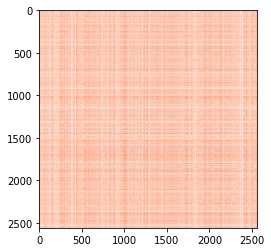

In [73]:
plt.imshow(np.log(otda.coupling_ + 1e-12), cmap='Reds')

Note that we cannot see much structure in $\pi$. This is because source and target samples are not ordered with respect to their classes. Intuitively, samples within the same class are close to each other (e.g. ones in MNIST are closer to ones in USPS), thus we expect $\pi$ to be __class sparse__. This notion was introduced in [1], and corresponds to the following:

$$\pi_{ij} \neq 0 \iff y_{S}^{i} \neq y_{T}^{j}$$

Of course, this property is not properly enforced as we did not use the label information when fitting $\pi$. If we sort the rows and columns of $\pi$ by the label vectors, we can see if this property is respected,

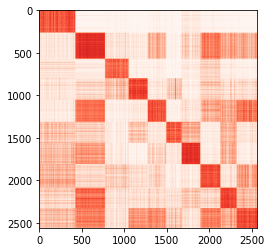

In [69]:
plt.imshow(np.log(otda.coupling_[_Ys.argsort(), :][:, _Yt.argsort()] + 1e-12), cmap='Reds')

note that $\pi$ is approximately class-sparse, reflecting the fact that features are somewhat enough to induce this desirable property.

### Why Class Sparsity?

Right now, you may be wondering __why__ class sparsity is important. Well, let us take a look on __where__ samples $\mathbf{x}_{S}^{i}$ are transported to. For a given $i$, it is mapped to,

$$\hat{\mathbf{x}}_{S}^{i} = \sum_{j=1}^{n_{T}}(n_{S}\pi_{ij})\mathbf{x}_{T}^{j}.$$

Calling $\alpha_{j} = n_{S}\pi_{ij}$, note that $\sum_{j}\alpha_{j} = 1$, and $\alpha_{j} \geq 0$. This means that $\hat{\mathbf{x}}_{S}^{i}$ lies on the [__convex hull__](https://en.wikipedia.org/wiki/Convex_hull) of samples $\mathbf{x}_{T}^{j}$ that receive mass from $\mathbf{x}_{S}^{i}$.

Now, let us take this situation to its extreme. Suppose that all $\mathbf{x}_{T}^{j}$ for which $\pi_{ij} > 0$ belong to a single class $k_{j}$ that differs from $k_{i}$. This means that $\mathbf{x}_{S}^{i}$ will be transported to the wrong region of the decision boundary, thus harming adaptation performance. In other words, if $\mathbf{x}_{S}^{i}$ corresponds to a $1$, and all $\mathbf{x}_{T}^{j}$ are $8$'s, $\hat{x}_{S}^{i}$ will be closer to an $8$ than to a $1$.

### Transporting and Evaluating on Target Domain

Now, we get to our final step, where we measure the success of adaptation. First we need to extract features from source domain samples, then transport them to the target domain. This is done by composing the feature extractor with the mapping $T_{\pi}$,

$$\hat{h}_{S}^{i} = T_{\pi}(\phi(\mathbf{x}_{S}^{i}))$$

In [70]:
THs, Ys = [], []
for xs, ys in tqdm(src_loader):
    with torch.no_grad():
        hs, _ = model(xs)
        hs = torch.from_numpy(otda.transform(hs.numpy()))
        THs.append(hs)
    Ys.append(ys)
THs = torch.cat(THs, dim=0)
Ys = torch.cat(Ys, dim=0)

100%|██████████| 235/235 [01:15<00:00,  3.11it/s]


In order to avoid overflowing the memory, we calculate the distance of mini-batches of target domain samples to the transported features,

In [71]:
Yp = torch.zeros_like(Yt)
num_batches = len(Ht) // 64 + 1
for i in tqdm(range(num_batches), total=num_batches):
    ht = Ht[i * 64: (i + 1) * 64]
    C = torch.cdist(THs, ht, 2) ** 2
    ind_opt = C.argmin(dim=0)
    Yp[i * 64: (i + 1) * 64] = Ys[ind_opt]

100%|██████████| 114/114 [00:13<00:00,  8.41it/s]


In [72]:
print(accuracy_score(Yt, Yp))

0.7860375805787958


That is, we gained $7\%$ in terms of performance, which represents a gain of roughly $10\%$ in accuracy.

## Want to Know More?

Optimal Transport has made a significant impact on the machine learning community in past 10 years. If you are interested in more resources and papers on the interplay between OT and Transfer Learning, you can consider looking on,

* How to induce specific structures (e.g. classes) in OT maps [1, 6]
* Solving issues w/ extending barycentric mappings [6, 10]
* OTDA on joint distributions [11, 12]
* Multi-Source Domain Adaptation [13, 14]

## References

[1] N. Courty, R. Flamary, D. Tuia, and A. Rakotomamonjy, “Optimal transport for domain
adaptation,” IEEE transactions on pattern analysis and machine intelligence, vol. 39, no. 9,
pp. 1853–1865, 2016.

[2] Peyré, G., & Cuturi, M. (2019). Computational optimal transport: With applications to data science. Foundations and Trends® in Machine Learning, 11(5-6), 355-607.

[3] Y. LeCun, B. Boser, J. S. Denker, D. Henderson, R. E. Howard, W. Hubbard, and L. D. Jackel, “Backpropagation applied to handwritten zip code recognition,” Neural computation, vol. 1, no. 4, pp. 541–551, 1989.

[4] J. J. Hull, “A database for handwritten text recognition research,” IEEE Transactions on pattern analysis and machine intelligence, vol. 16, no. 5, pp. 550–554, 1994

[5] Ganin, Y., Ustinova, E., Ajakan, H., Germain, P., Larochelle, H., Laviolette, F., ... & Lempitsky, V. (2016). Domain-adversarial training of neural networks. The journal of machine learning research, 17(1), 2096-2030.

[6] Seguy, V., Damodaran, B. B., Flamary, R., Courty, N., Rolet, A., & Blondel, M. (2017). Large-scale optimal transport and mapping estimation. arXiv preprint arXiv:1711.02283.

[7] Villani, C. (2009). Optimal transport: old and new (Vol. 338, p. 23). Berlin: springer.

[8] Cuturi, M. (2013). Sinkhorn distances: Lightspeed computation of optimal transport. Advances in neural information processing systems, 26.

[9] Ferradans, S., Papadakis, N., Peyré, G., & Aujol, J. F. (2014). Regularized discrete optimal transport. SIAM Journal on Imaging Sciences, 7(3), 1853-1882.

[10] Perrot, M., Courty, N., Flamary, R., & Habrard, A. (2016). Mapping estimation for discrete optimal transport. Advances in Neural Information Processing Systems, 29.

[11] Courty, N., Flamary, R., Habrard, A., & Rakotomamonjy, A. (2017). Joint distribution optimal transportation for domain adaptation. Advances in Neural Information Processing Systems, 30.

[12] Damodaran, B. B., Kellenberger, B., Flamary, R., Tuia, D., & Courty, N. (2018). Deepjdot: Deep joint distribution optimal transport for unsupervised domain adaptation. In Proceedings of the European Conference on Computer Vision (ECCV) (pp. 447-463).

[13] Nguyen, T., Le, T., Zhao, H., Tran, Q. H., Nguyen, T., & Phung, D. (2021, December). Most: Multi-source domain adaptation via optimal transport for student-teacher learning. In Uncertainty in Artificial Intelligence (pp. 225-235). PMLR.

[14] Montesuma, E. F., & Mboula, F. M. N. (2021). Wasserstein Barycenter for Multi-Source Domain Adaptation. In Proceedings of the IEEE/CVF Conference on Computer Vision and Pattern Recognition (pp. 16785-16793).